In [1]:
from __future__ import division
from utils import *
from functions import *
from cycler import cycler
import matplotlib as mpl
%matplotlib inline
from numba import autojit

%load_ext autoreload
%autoreload 2

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000 - PhD/figures/"+todayStr+"/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
    
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Instantiate classes
cortex = Cortex()
trn = TRN()
gr = GRAPH(cortex)

# styling
gammaColor = '#00cc99'

def xax(gamma, duration):
    x= np.arange(0,(duration-1)/1000,(duration)/1000/len(gamma) )
    return x

@autojit
def resonanceFS(F, tauv=15):
    T = 2000
    dt = 1
    t = np.arange(0, T, dt)
    F = np.logspace(0.5, 2.3, 200)

    res_var = np.empty(len(F), dtype=np.float64)
    b = 2
    for k, f in enumerate(F):
        A = 0.01
        I = A * np.cos(2 * np.pi * f * t / 1000)
        res_v = []
        res_u = []
        u = 0
        t_rest = 0

        # izh neuron model for cortical fast spiking neurons (that burst)
        v = -60
        for i in range(len(t)):
            v += dt / tauv * ((v + 60) * (v + 50) - 20 * u + 8 * I[i])
            u += dt * 0.044 * ((v + 55) - u)
            if v > 25:
                v = -40
                u += 50
            if i * dt > 1500:
                res_v.append(v / A)

        var = np.var(res_v)
        #         var = np.max(res_v)-np.min(res_v)
        res_var[k] = var
    return res_var

def plotWeights(tauv=15):
    spikes_x, spikes_y, spikes_x_tc, spikes_y_tc, \
    gamma, correlation, ssp1, \
    stimulation, p, q, LowSp, vm = cortex.readSimulation(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, 
                                                         WII=WII, LTP=LTP, LTD=LTD, 
                                                         model=model, glob=glob, sG=sG, sWII=sWII, tauv=tauv)

    titlestr = r'$N=%d$  $\frac{\alpha_{LTP}}{\alpha_{LTD}}=%d$  $g_0=%.1f$  $\nu=%d$ $sG=%d$ $sW_{II}=%d$ $LTD=%.6g$ $\tau_v=%d$' \
               % (N, ratio, G, sigma, sG, sWII, LTD, tauv)
    titlestr2 = 'N=%d  LTD/LTP=%d g0=%.1f  nu=%d  sG=%d sWII=%d' % (N, ratio, G, sigma, sG, sWII)

    GAP2D = cortex.readMatrix(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, 
                              WII=WII, LTP=LTP, LTD=LTD, 
                              model=model, glob=glob, type="GAP", sG=sG, sWII=sWII, tauv=tauv)
    GAP2D0 = cortex.readMatrix(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, 
                               WII=WII, LTP=LTP, LTD=LTD, 
                               model=model, glob=glob, type="GAP0", sG=sG, sWII=sWII, tauv=tauv)
    WII2D = cortex.readMatrix(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, 
                              WII=WII, LTP=LTP, LTD=LTD, 
                              model=model, glob=glob, type='WII', sG=sG, sWII=sWII, tauv=tauv)
    fig = plt.figure(figsize=(12, 12))

    fontsize = 10
    matplotlib.rc('xtick', labelsize=fontsize)
    matplotlib.rc('ytick', labelsize=fontsize)
    matplotlib.rc('axes', labelsize=fontsize)
    matplotlib.rc('axes', titlesize=fontsize)

    ax0 = fig.add_subplot(321)
    ax0.plot(xax(gamma, d1 + d2 + d3), gamma, color='c')

    ax01 = fig.add_subplot(322)
    T = 2000
    dt = 1
    t = np.arange(0, T, dt)
    F = np.logspace(0.5, 2.3, 200)
    mod = resonanceFS(F, tauv=tauv)
    mod15 = resonanceFS(F, tauv=15)
    ax01.semilogx(F, mod / np.nanmax(mod), label='%.1f' % (F[np.argmax(mod)]), color='c')
    ax01.semilogx(F, mod15 / np.nanmax(mod15), label='%.1f' % (F[np.argmax(mod15)]), color='r')
    ax01.set_ylim([0, 1.05])
    # plt.legend()
    ax01.set_xlabel('Stimulus Frequency [Hz]')
    ax01.set_ylabel('Normalised Response Amplitude')
    ax01.set_xlim([0, 200])
    ax01.set_title('Subthreshold Resonant Property', y=1.08)
    ax01.legend()

    ax1 = plt.subplot(334)
    # plt.imshow(np.array(GAP2D)[100:150,1:20], interpolation='nearest')
    im1 = ax1.imshow(np.array(GAP2D0), interpolation='nearest')
    ax1.set_title(r'$\gamma(t = 0)$')
    fig.colorbar(im1)
    # plt.figure(figsize=(10,10))
    ax2 = plt.subplot(335)
    im2 = ax2.imshow(np.array(GAP2D), interpolation='nearest')
    ax2.set_title(r'$\gamma(t = END)$')
    fig.colorbar(im2)
    # plt.figure(figsize=(10,10))
    ax3 = plt.subplot(336)
    im3 = ax3.imshow(np.array(WII2D), interpolation='nearest')
    ax3.set_title(r'$W_{II}$')

    ax1 = fig.add_subplot(325)
    ax2 = fig.add_subplot(326)
    gr.plotRaster(spikes_x[:5000], spikes_y[:5000], ax=ax1)
    gr.plotRaster(spikes_x[-5000:], spikes_y[-5000:], ax=ax2)
    plt.suptitle(titlestr)

    plt.savefig(DIRECTORY + "full_sWII-%d_sG-%d_WII-%d_G-%d_N-%d_t-%d_LTD-%d_tauv-%d.png" % (
    sWII, sG, WII, G, N, d1 + d2 + d3, LTD > 1e-8, tauv))
    del fig
    # gr.plotRasterGPU(spikes_x[:],spikes_y[:], "test_%s.html"%(str(G)), saveImg=0)
    return 0

TypeError: __init__() takes 1 positional argument but 2 were given

In [15]:
# #-------------------------------
# # PARAMS SEARCH
# #-------------------------------
N = 100
G = 10
d1 = 10
d2 = 10000
d3 = 10
before = d1
after = d2+d3
sigma = 60
WII = 1400 #2800
LTP = 0.01
LTD = 0.002
S = 100
model = "gp-izh-subnetworks"
glob = 0

# shared weights
sG = 15
sWII = 0

FACT = 1
r=0
it = 8
binsize=1000
coeff=1
ratio = 15
LTD  = 1e-0*4.7e-6 * FACT * N
LTP = ratio * LTD

tauv=95

# for S in np.arange(50,400,50):
#     Parallel(n_jobs=8)(delayed(cortex.runSimulation)(N,0, G, S, d1, d2, d3, before, after, sigma, \
# WII, LTP, LTD) for G in np.linspace(1,9,"8))

sWIIList = [10]
sGList = [0,1,5,10,15,20,25]
LTDList = [1e-9*4.7e-6 * FACT * N,1e-0*4.7e-6 * FACT * N]
taulist = np.arange(15,95,10)

# cortex.runSimulation(N=N,i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, before=before, after=after,\
#                                  s=sigma, WII=WII, LTP=LTP, LTD=LTD, model=model, r=r, glob=glob, sG=sG, sWII=sWII, tauv=tauv)

# plotWeights(tauv = tauv)


# for d2 in [60000]:
#         for sWII in sWIIList:
#             for sG in sGList:
#                 for LTD in LTDList:
#                     LTP = ratio * LTD
#                     Parallel(n_jobs=8)(delayed(cortex.runSimulation)(N=N,i=0, g=G, S=S, 
#                                                                      d1=d1, d2=d2, d3=d3, 
#                                                                      before=before, after=after,
#                                          s=sigma, WII=WII, LTP=LTP, LTD=LTD, 
#                                                                      model=model, r=r, glob=glob, 
#                                                                      sG=sG, sWII=sWII, tauv=tauv) for tauv in taulist)
                    
                    
# for tauv in taulist:
#     for d2 in [60000]:
#         for sWII in sWIIList:
#             for sG in sGList:
#                 for LTD in LTDList:
#                     LTP = ratio * LTD
#                     plotWeights(tauv=tauv)



In [88]:
tauv = 15
sG = 20
sWII= 10
LTD = 1e-0*4.7e-6 * FACT * N
LTP = ratio * LTD
d2=60000

cortex.runSimulation(N=N,i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, before=before, after=after,\
                                 s=sigma, WII=WII, LTP=LTP, LTD=LTD, model=model, r=r, glob=glob, sG=sG, sWII=sWII, tauv=tauv)


spikes_x, spikes_y, spikes_x_tc, spikes_y_tc, \
                   gamma, correlation, ssp1, \
    stimulation, p, q, LowSp, vm, lfp1, lfp2 = cortex.readSimulation(N=N, r=r, i=0, g=G, S=S, d1=d1, d2=d2, d3=d3, \
                                                            WII=WII, LTP=LTP, LTD=LTD, \
                                                            model=model, glob=glob, sG=sG, sWII=sWII, tauv=tauv, with_currents=True )


./cortex -N 100 -ext _0.txt -d1 10 -d2 60000 -d3 10 -before 10 -after 10010 -S 100 -G 10 -s 60 -WII 1400 -LTP 0.00705 -LTD 0.00047 -model gp-izh-subnetworks -r 0 -global 0 -sG 20 -sWII 10 -tauv 15


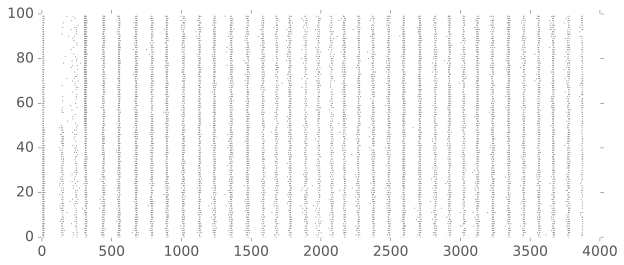

In [89]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
gr.plotRaster(spikes_x[0:10000], spikes_y[0:10000], ax=ax)

In [90]:
matSize = len(spikes_x)
ones = np.ones(matSize)
A = sparse.csc_matrix((ones,(spikes_x,spikes_y)),shape=(matSize,matSize))

In [91]:
def reshape(LFP1):
    return np.reshape(np.array(LFP1),(len(LFP1),))

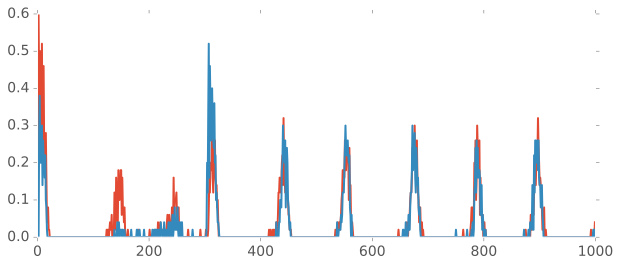

In [92]:
MUA1 = reshape(A[:,0:50].mean(axis=1))
MUA2 = reshape(A[:,50:100].mean(axis=1))

plt.plot(MUA1[:1000])
plt.plot(MUA2[:1000])

## Phase locking between LFP1 and LFP2

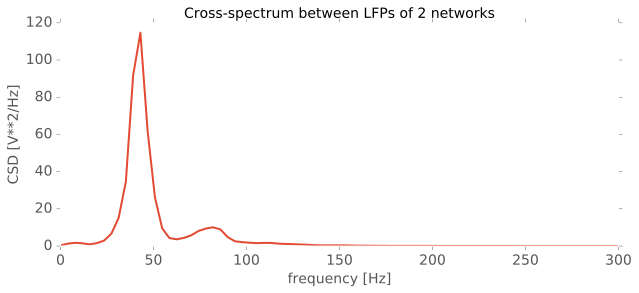

In [118]:
f, Pxy = signal.csd(i1[-40000:], i2[-40000:], fs=1/0.00025, nperseg=1024)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f, np.abs(Pxy))
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('CSD [V**2/Hz]')
ax.set_xlim([0,300])
ax.set_title('Cross-spectrum between LFPs of 2 networks')

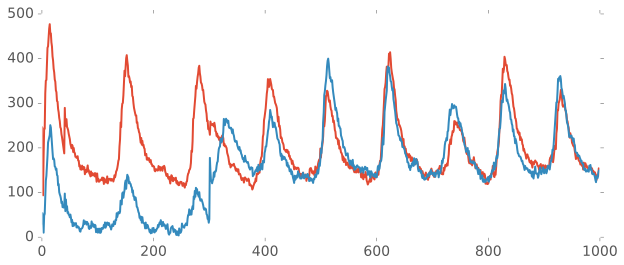

In [95]:
plt.plot(i1[0:1000])
plt.plot(i2[0:1000])
# plt.ylim([0,2])

## Phase locking between MUA1 and LFP1

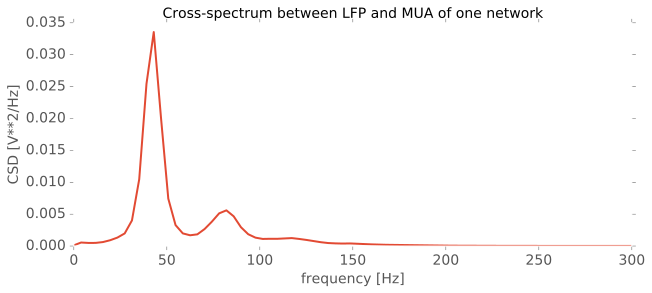

In [102]:
f, Pxy = signal.csd(lfp1, MUA1, fs=1/0.00025, nperseg=1024)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f, np.abs(Pxy))
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('CSD [V**2/Hz]')
ax.set_xlim([0,300])
ax.set_title('Cross-spectrum between LFP and MUA of one network')

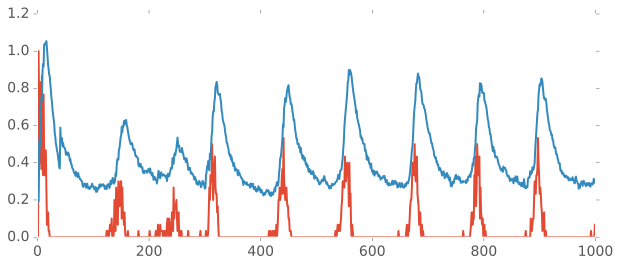

In [116]:
plt.plot(MUA1[0:1000]/np.max(MUA1))
plt.plot(lfp1[0:1000]/np.max(i1))

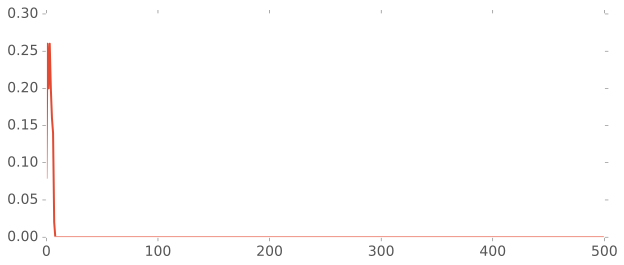

In [81]:
plt.plot(MUA1[60000:60500])

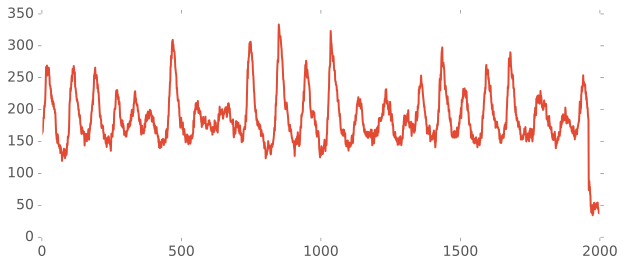

In [72]:
plt.plot(lfp1[-2000:])

In [119]:
np.arange(10)[-3:-1]

array([7, 8])